1. Prepare the necessary preprocessing steps for both models, utilizing existing resources if
available.

In [92]:
pwd

'C:\\Users\\berka'

In [93]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Veri setini yükleme
data = pd.read_csv("C:\\Users\\berka\\OneDrive\\Masaüstü\DS-Task\\application_train.csv")  # Dosyanın yolunu doğru ayarlayın
print(f"Veri setinin boyutları: {data.shape}")
data.head()  # İlk 5 satırı görüntüle

Veri setinin boyutları: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


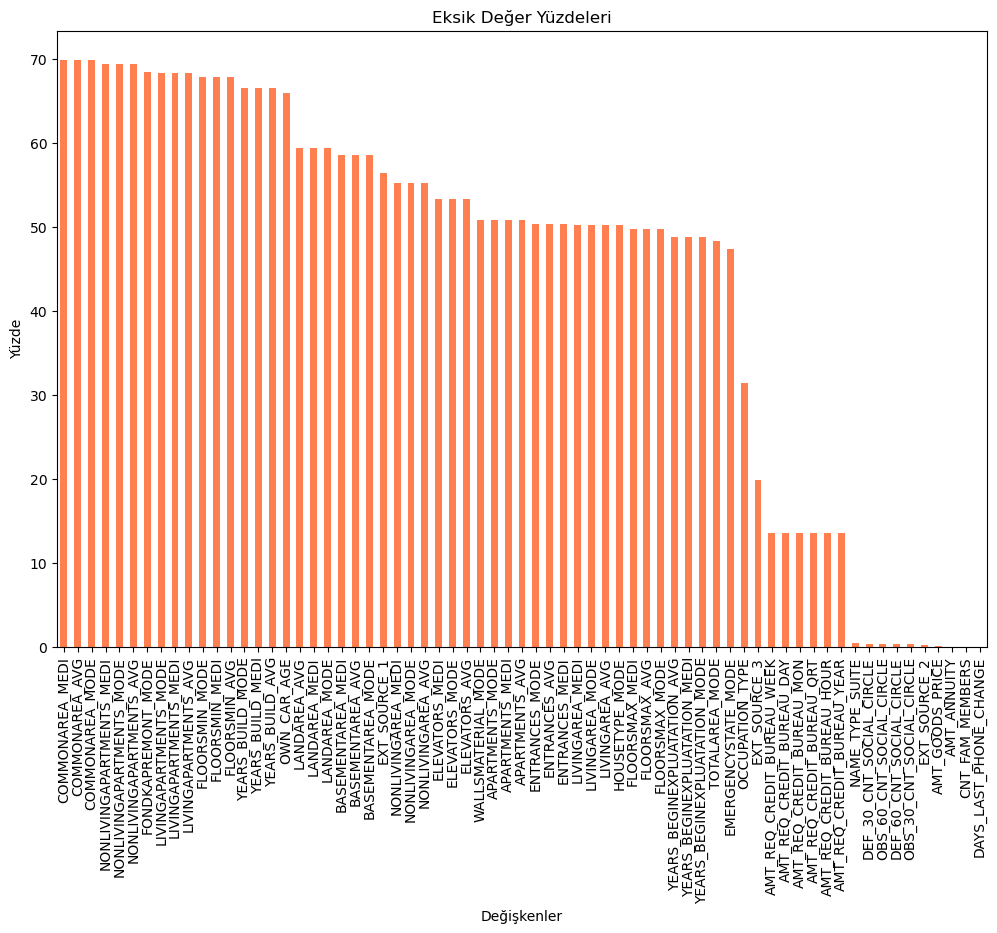

In [94]:
# Eksik değerlerin yüzdesini hesaplayalım
missing_values = data.isnull().sum() / len(data) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Görselleştirme
plt.figure(figsize=(12, 8))
missing_values.plot(kind="bar", color="coral")
plt.title("Eksik Değer Yüzdeleri")
plt.xlabel("Değişkenler")
plt.ylabel("Yüzde")
plt.show()

In [95]:
# Kategorik ve sayısal değişkenleri ayıralım
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

print(f"Kategorik Değişken Sayısı: {len(categorical_columns)}")
print(f"Sayısal Değişken Sayısı: {len(numerical_columns)}")


Kategorik Değişken Sayısı: 16
Sayısal Değişken Sayısı: 106


In [96]:
# Kategorik değişkenlerde en sık görülen değeri kullanarak doldurma
for col in categorical_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Sayısal değişkenlerde ortalama ile doldurma
for col in numerical_columns:
    data[col].fillna(data[col].mean(), inplace=True)


In [97]:
# One-Hot Encoding
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
print(f"Yeni veri setinin boyutları: {data.shape}")


Yeni veri setinin boyutları: (307511, 230)


2. Determine the appropriate validation strategy for model validation (e.g., KFold,
StratifiedKFold).

In [99]:
from sklearn.model_selection import KFold

# KFold doğrulama
kf = KFold(n_splits=5, shuffle=True, random_state=42)

3. Provide initial prediction results with simple parameters for both models.

In [101]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

# Hedef ve özellikleri ayırma
X = data.drop("TARGET", axis=1)
y = data["TARGET"]

# CatBoost Basit Model
catboost_model = CatBoostClassifier(iterations=100, verbose=0, random_seed=42)
catboost_model.fit(X, y)
catboost_preds = catboost_model.predict_proba(X)[:, 1]
print(f"CatBoost ROC-AUC: {roc_auc_score(y, catboost_preds)}")


CatBoost ROC-AUC: 0.7861687050860733


In [102]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Ölçeklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ridge Model
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_scaled, y)
ridge_preds = ridge_model.predict(X_scaled)
print(f"Ridge ROC-AUC: {roc_auc_score(y, ridge_preds)}")


Ridge ROC-AUC: 0.748301909949598


4. Perform feature selection using lofo-importance 

In [104]:
from lofo import LOFOImportance, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# LOFO Dataset oluşturma
lofo_dataset = Dataset(df=data, target="TARGET", features=X.columns.tolist())

# LOFO Importance - ROC-AUC metriği ile
lofo = LOFOImportance(
    lofo_dataset, 
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring="roc_auc"
)

# Özellik önem sırasını hesaplama
importance_df = lofo.get_importance()

# Özellik önemini görselleştirme
lofo.plot_importance(importance_df)


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11476
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 149
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19888, number of negative: 226121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11590
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 149
[LightGBM]

  0%|          | 0/229 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11221
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 148
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19888, number of negative: 226121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11335
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 148
[LightGBM]

AttributeError: 'LOFOImportance' object has no attribute 'plot_importance'

In [109]:
# Özellik Önemini Sıralama
importance_df = importance_df.sort_values(by="mean_importance", ascending=False)

# Barplot ile Görselleştirme
plt.figure(figsize=(12, 8))
sns.barplot(x=importance_df["mean_importance"], y=importance_df["feature"], palette="viridis")
plt.title("LOFO Importance")
plt.xlabel("Mean Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

KeyError: 'mean_importance'

In [111]:
!pip install optuna-integration[catboost]

5. Implement hyperparameter optimization using techniques such as Grid Search, Random
Search, or Bayesian Search. If possible, consider using Optuna

In [113]:
import optuna
from optuna.integration import CatBoostPruningCallback

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10),
    }
    model = CatBoostClassifier(**params, verbose=0, random_seed=42)
    model.fit(X, y)
    preds = model.predict_proba(X)[:, 1]
    return roc_auc_score(y, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print(study.best_params)


[I 2024-12-24 14:50:16,178] A new study created in memory with name: no-name-f486ef79-7c7c-4e80-99c0-f0577e6de8a2
[I 2024-12-24 14:50:28,327] Trial 0 finished with value: 0.7784058050410234 and parameters: {'iterations': 230, 'depth': 5, 'learning_rate': 0.19461715633087256, 'l2_leaf_reg': 6.37682125106943}. Best is trial 0 with value: 0.7784058050410234.
[I 2024-12-24 14:51:00,768] Trial 1 finished with value: 0.8103106021527813 and parameters: {'iterations': 559, 'depth': 6, 'learning_rate': 0.13123863434028613, 'l2_leaf_reg': 0.2241906456545499}. Best is trial 1 with value: 0.8103106021527813.
[I 2024-12-24 14:51:32,416] Trial 2 finished with value: 0.8358570997527466 and parameters: {'iterations': 552, 'depth': 6, 'learning_rate': 0.280764656406856, 'l2_leaf_reg': 4.70798427593052}. Best is trial 2 with value: 0.8358570997527466.
[I 2024-12-24 14:51:44,327] Trial 3 finished with value: 0.8064401942411181 and parameters: {'iterations': 102, 'depth': 9, 'learning_rate': 0.22611205840

{'iterations': 988, 'depth': 10, 'learning_rate': 0.0769292064098567, 'l2_leaf_reg': 0.3117736964637824}


6. Demonstrate how your choices from step 3 to step 5 have improved model performance,
documenting the pros and cons of each experiment.

In [115]:
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.model_selection import KFold



importance_df = lofo.get_importance()
importance_df = importance_df.sort_values(by="mean_importance", ascending=False)
# 1. Basit Model Sonuçları
catboost_model_simple = CatBoostClassifier(iterations=100, verbose=0, random_seed=42)
catboost_model_simple.fit(X, y)
catboost_preds_simple = catboost_model_simple.predict_proba(X)[:, 1]
roc_auc_simple = roc_auc_score(y, catboost_preds_simple)

# 2. Özellik Seçimi Sonrası Sonuçlar
selected_features = importance_df[importance_df["mean_importance"] > 0]["feature"]
X_selected = X[selected_features]
catboost_model_fs = CatBoostClassifier(iterations=100, verbose=0, random_seed=42)
catboost_model_fs.fit(X_selected, y)
catboost_preds_fs = catboost_model_fs.predict_proba(X_selected)[:, 1]
roc_auc_fs = roc_auc_score(y, catboost_preds_fs)

# 3. Hiperparametre Optimizasyonu Sonrası Sonuçlar
optuna_params = {
    "iterations": study.best_params["iterations"],
    "depth": study.best_params["depth"],
    "learning_rate": study.best_params["learning_rate"],
    "l2_leaf_reg": study.best_params["l2_leaf_reg"],
}
catboost_model_opt = CatBoostClassifier(**optuna_params, verbose=0, random_seed=42)
catboost_model_opt.fit(X_selected, y)
catboost_preds_opt = catboost_model_opt.predict_proba(X_selected)[:, 1]
roc_auc_opt = roc_auc_score(y, catboost_preds_opt)

# Sonuçları Yazdırma
print(f"Basit Model ROC-AUC: {roc_auc_simple:.4f}")
print(f"Özellik Seçimi Sonrası ROC-AUC: {roc_auc_fs:.4f}")
print(f"Hiperparametre Optimizasyonu Sonrası ROC-AUC: {roc_auc_opt:.4f}")


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11476
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 149
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19888, number of negative: 226121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11590
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 149
[LightGBM]

  0%|          | 0/229 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11221
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 148
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Info] Number of positive: 19888, number of negative: 226121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11335
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 148
[LightGBM]

KeyError: 'mean_importance'

7. Interpret model variables using SHAP values.

In [117]:
import shap

# SHAP değerlerini hesaplama
explainer = shap.Explainer(catboost_model)
shap_values = explainer(X)

# SHAP Özet Grafiği
shap.summary_plot(shap_values, X)


MemoryError: Unable to allocate 540. MiB for an array with shape (307511, 230) and data type float64